## Importing Dataset + Visualization

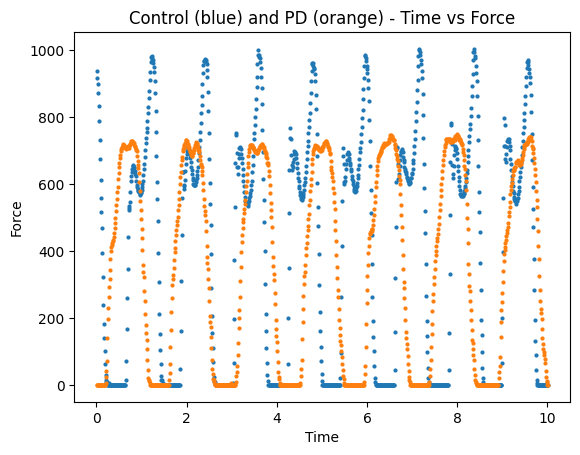

In [61]:
# This file will be used to start developping the preprocessing of the data pipeline
# Consisting of feature selection and dimension reduction

import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Import dataset
features = ['Time', 'Left Foot Force', 'Right Foot Force']
dataset_dir_control = "csv_averaged_force_data_4col/GaCo04_01.csv"
dataset_dir_pd = "csv_averaged_force_data_4col/GaPt03_01.csv"

# Read the csv
df_control = pd.read_csv(dataset_dir_control).head(1001)
df_control.columns = features

df_pd = pd.read_csv(dataset_dir_pd).head(1001)
df_pd.columns = features

# Plotting a subset of the data
fname = 'Right Foot Force'

plt.figure(1)
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Control (blue) and PD (orange) - Time vs Force')
plt.plot(df_control.Time, df_control[fname], marker = 'o', markersize = 2, linestyle='None')
plt.plot(df_pd.Time, df_pd[fname], marker = 'o', markersize = 2, linestyle = 'None')
plt.show()


# Sinusoidal Curve Fitting Analysis (Signal Processing)

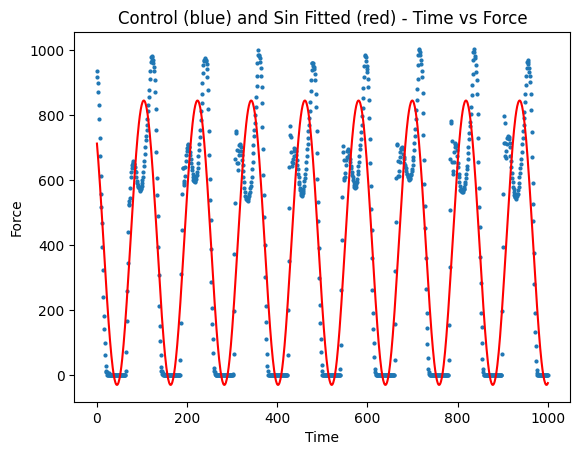

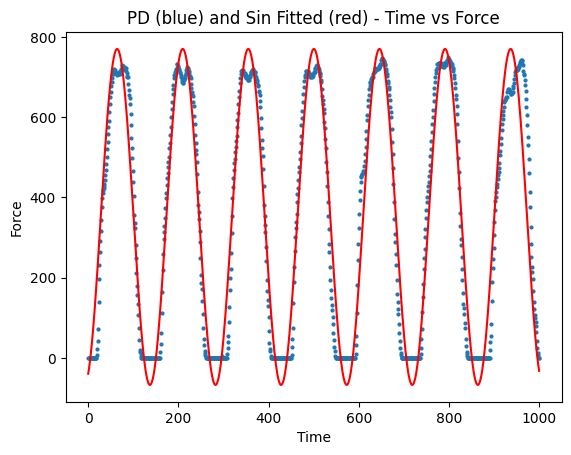

In [69]:
# Getting the data
control_x_values = df_control.Time.values
control_rightForce_values = df_control[fname].values

pd_x_values = df_pd.Time.values
pd_rightForce_values = df_pd[fname].values

# Initial guesses for the fits
p0_control = [(5/4)*np.pi,
      20,
      0,
      np.mean(control_rightForce_values)]

p0_pd = [(5/4)*np.pi,
      10,
      0,
      np.mean(pd_rightForce_values)]

# Defining the sin function
def sinusoidal(x, omega, A, phi, offset):
    return A*np.sin(omega*x + phi) + offset

# Finding the fitted curve parameters
fit_control = curve_fit(sinusoidal, control_x_values, control_rightForce_values, p0=p0_control, maxfev=10000)
fit_pd = curve_fit(sinusoidal, pd_x_values, pd_rightForce_values, p0=p0_pd, maxfev=10000)

# Evaluating the new fitted curve
y_fit_control = sinusoidal(control_x_values, *fit_control[0])
y_fit_pd = sinusoidal(pd_x_values, *fit_pd[0])

# Plotting the initial data with the fitted curve
plt.figure(2)
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('Control (blue) and Sin Fitted (red) - Time vs Force')
plt.plot(df_control[fname], marker = 'o', markersize = 2, linestyle='None')
plt.plot(y_fit_control, color='r')
plt.show()

plt.figure(3)
plt.xlabel('Time')
plt.ylabel('Force')
plt.title('PD (blue) and Sin Fitted (red) - Time vs Force')
plt.plot(df_pd[fname], marker = 'o', markersize = 2, linestyle='None')
plt.plot(y_fit_pd, color='r')
plt.show()

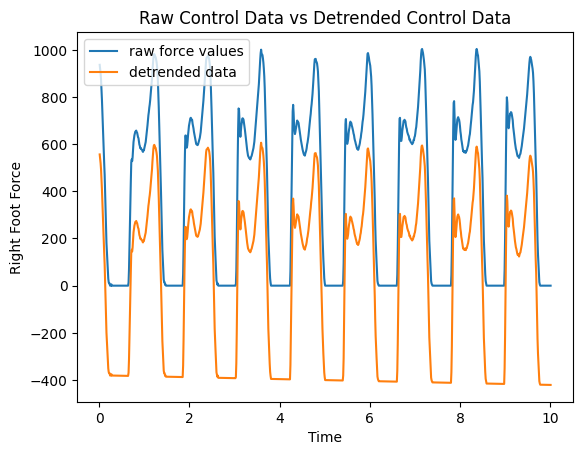

c:\Users\John\Documents\WINTER 2024\BIEN 462\BIEN-462-Projects\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\John\Documents\WINTER 2024\BIEN 462\BIEN-462-Projects\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


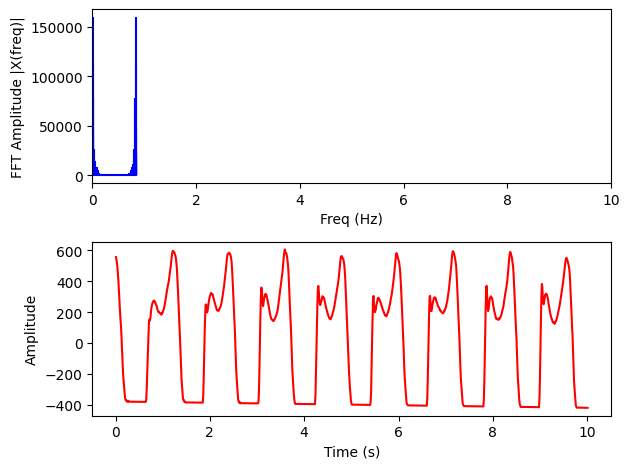

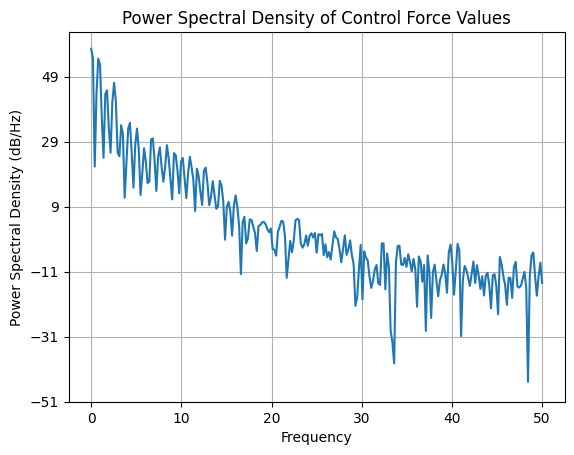

In [83]:
# Signal Processing (for control only to start )
from scipy import signal
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Getting the data
control_x_values = df_control.Time.values
control_rightForce_values = df_control[fname].values

rightForce_detrend = signal.detrend(control_rightForce_values)

# Showing the detrended data
plt.plot(control_x_values, control_rightForce_values, label="raw force values")
plt.plot(control_x_values, rightForce_detrend, label = "detrended data")
plt.title("Raw Control Data vs Detrended Control Data")
plt.ylabel("Right Foot Force")
plt.xlabel("Time")
plt.legend()
plt.show()

# Performing a frequency analysis FFT (attempted)

# Parameters im not sure about 
sr = fit_control[0][0]/(2*np.pi)
ts = 1/sr

X = np.fft.fft(rightForce_detrend)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.subplot(2,1,1)
plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(2,1,2)
plt.plot(control_x_values, np.fft.ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Performing a power spectral density (attempted)
plt.figure()
plt.psd(control_rightForce_values, 512, 1/0.01)
plt.title("Power Spectral Density of Control Force Values")
plt.show()

## All Datasets calculating Stride Time

In [ ]:
for name in os.listdir('csv_averaged_force_data_4col'):
    if 'Co' in name or 'Pt' in name:

        features = ['Time', 'Left Foot Force', 'Right Foot Force']
        df = pd.read_csv('csv_averaged_force_data_4col/' + name)
        df.columns = features
        
        t_strideIntervals = []
        startTime = None

        # Calculating stride time 
        for index, row in df.iterrows():
            
            # This means that the stride has been initiated 
            if (row[features[2]] == 0) & (startTime is None):
                startTime = row[features[0]]
            
            # This means that the stride has been stopped
            elif (row[features[2]] != 0) & (startTime is not None):
                t_strideIntervals.append((startTime, row[features[0]]))
                startTime = None
        
            # Duration of each interval
            t_strideDurations = [(end - start) for start,end in t_strideIntervals]

            # Converting the data into a pandas dataframe
            strideTime = np.array(t_strideDurations)
            df_strideTime = pd.DataFrame(strideTime)

        nameStrideTime = 'StrideFiles/StrideTime' + name.split('.')[0] + ".csv"
        df_strideTime.to_csv(nameStrideTime, index = None)
        
 

## Extracting Stride Time (Individual Set Comparing )

In [4]:
df_control = pd.read_csv(dataset_dir_control)
df_control.columns = features

df_pd = pd.read_csv(dataset_dir_pd)
df_pd.columns = features


## To calculate the time of each stride we can calculate the time between each zero force plateau 

### FOR PD PATIENT
t_strideIntervals_pd = []
startTime_pd = None

for index, row in df_pd.iterrows():
    
    # This means that the stride has been initiated 
    if (row[features[2]] == 0) & (startTime_pd is None):
        startTime_pd = row[features[0]]
    
    # This means that the stride has been stopped
    elif (row[features[2]] != 0) & (startTime_pd is not None):
        t_strideIntervals_pd.append((startTime_pd, row[features[0]]))
        startTime_pd = None
    
# Duration of each interval
t_strideDurations_pd = [(end - start) for start,end in t_strideIntervals_pd]

print("The PD Patient had a stride time average of " + str(np.mean(t_strideDurations_pd)) + " and a standard deviation of " + str(np.std(t_strideDurations_pd)))
print(len(t_strideDurations_pd))


### FOR CONTROL PATIENT
t_strideIntervals_control = []
startTime_control = None

for index, row in df_control.iterrows():
    
    # This means that the stride has been initiated 
    if (row[features[2]] == 0) & (startTime_control is None):
        startTime_control = row[features[0]]
    
    # This means that the stride has been stopped
    elif (row[features[2]] != 0) & (startTime_control is not None):
        t_strideIntervals_control.append((startTime_control, row[features[0]]))
        startTime_control = None
    
# Duration of each interval
t_strideDurations_control = [(end - start) for start,end in t_strideIntervals_control]

# for interval, duration in zip(t_strideIntervals_pd, t_strideDurations_control):
#     print(f"Zero force interval: {interval}, Duration: {duration} units of time")


print("The Control Patient had a stride time average of " + str(np.mean(t_strideDurations_control)) + " and a standard deviation of " + str(np.std(t_strideDurations_control)))
print(len(t_strideDurations_control))

The PD Patient had a stride time average of 0.3484404761904764 and a standard deviation of 0.12792789088560738
84
The PD Patient had a stride time average of 0.39366407766990313 and a standard deviation of 0.09038361808604442
103
